In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc

In [3]:
grids = [(5,5), (8,8), (10,10), (12,12), (15,15)]

In [4]:
def lighten(color, amount=0.9):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [5]:
def drawPlot(grids, n, d, e):
    regrets, elapses = getRow(grids, n, d, e)
    # color map
    cset =  tc.tol_cset('light')
    cmap = tc.tol_cmap("rainbow_discrete")(np.linspace(0, 1, 22))
    colors = [cset.mint, cset.pink, cmap[16], cmap[7], cmap[10], cmap[5]]
    for i in range(len(colors)):
        colors[i] = lighten(colors[i])
    # x tick
    x = np.array([i for i in range(len(grids))])
    # time
    fig = plt.figure(figsize=(16, 8))
    c = colors[0]
    plt.plot(x, elapses["lr"]["mean"], linewidth=5, color=c)
    plt.errorbar(x-0.012, elapses["lr"]["mean"], elapses["lr"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3)
    c = colors[1]
    plt.plot(x, elapses["rf"]["mean"], linewidth=5, color=c)
    plt.errorbar(x-0.004, elapses["rf"]["mean"], elapses["rf"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3)
    c = colors[2]
    plt.plot(x, elapses["spo"]["mean"], linewidth=5, color=c)
    plt.errorbar(x+0.004, elapses["spo"]["mean"], elapses["spo"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3)
    c = colors[3]
    plt.plot(x, elapses["dbb"]["mean"], linewidth=5, color=c)
    plt.errorbar(x+0.012, elapses["dbb"]["mean"], elapses["dbb"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3)
    plt.ylim(0, 600)
    plt.xticks(x, labels=["{}x{}".format(g[0], g[1]) for g in grids], fontsize=28)
    plt.yticks(fontsize=24)
    plt.xlabel("Graph Size", fontsize=36)
    plt.ylabel("Time (Sec)", fontsize=36)
    plt.title("Training Time on Shortest Path\nTraining Set Size = {}, Polynomial Degree = {}, Noise Half−width = {}"
              .format(n,d,e),
              fontsize=30)
    plt.legend(["2-stage LR", "2-stage RF", "SPO+","DBB"], fontsize=24, ncol=2)
    plt.show()
    fig.savefig("./images/scale-sp-n{}d{}e{}-time.pdf".format(n,d,int(10*e)), dpi=300)
    # loss
    fig = plt.figure(figsize=(16, 8))
    c = colors[0]
    plt.plot(x, regrets["lr"]["mean"], linewidth=5, color=c)
    plt.errorbar(x-0.012, regrets["lr"]["mean"], regrets["lr"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3)
    c = colors[1]
    plt.plot(x, regrets["rf"]["mean"], linewidth=5, color=c)
    plt.errorbar(x-0.004, regrets["rf"]["mean"], regrets["rf"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3)
    c = colors[2]
    plt.plot(x, regrets["spo"]["mean"], linewidth=5, color=c)
    plt.errorbar(x+0.004, regrets["spo"]["mean"], regrets["spo"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3)
    c = colors[3]
    plt.plot(x, regrets["dbb"]["mean"], linewidth=5, color=c)
    plt.errorbar(x+0.012, regrets["dbb"]["mean"], regrets["dbb"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3)
    plt.ylim(0, 0.22)
    plt.xticks(x, labels=["{}x{}".format(w,h) for w,h in grids], fontsize=28)
    plt.yticks(fontsize=24)
    plt.xlabel("Graph Size", fontsize=36)
    plt.ylabel("Normalized Regret", fontsize=36)
    plt.title("Test Loss on Shortest Path\nTraining Set Size = {}, Polynomial Degree = {}, Noise Half−width = {}".
              format(n,d,e),
              fontsize=30)
    plt.legend(["2-stage LR", "2-stage RF", "SPO+","DBB"], fontsize=24, ncol=2)
    plt.show()
    fig.savefig("./images/scale-sp-n{}d{}e{}-loss.pdf".format(n,d,int(10*e)), dpi=300)

In [6]:
def getRow(grids, n, d, e):
    regrets = {"lr":{"mean":[],"std":[]}, "rf":{"mean":[],"std":[]}, "spo":{"mean":[],"std":[]}, "dbb":{"mean":[],"std":[]}}
    elapses = {"lr":{"mean":[],"std":[]}, "rf":{"mean":[],"std":[]}, "spo":{"mean":[],"std":[]}, "dbb":{"mean":[],"std":[]}}
    for g in grids:
        l, t = getData(g, n, d, e)
        for m in regrets:
            regrets[m]["mean"].append(l[m]["mean"])
            regrets[m]["std"].append(l[m]["std"])
            elapses[m]["mean"].append(t[m]["mean"])
            elapses[m]["std"].append(t[m]["std"])
    return regrets, elapses

In [7]:
def getData(grid, n, d, e):
    # dir
    dir_name = "./res/sp/h{}w{}/gurobi".format(grid[0], grid[1])
    file_name = {}
    file_name["lr"] = "n{}p5-d{}-e{}_2s-lr.csv".format(n,d,e)
    file_name["rf"] = "n{}p5-d{}-e{}_2s-rf.csv".format(n,d,e)
    file_name["spo"] = "n{}p5-d{}-e{}_spo_lr_adam0.01_bs32_l10.0l20.0_c8.csv".format(n,d,e)
    file_name["dbb"] = "n{}p5-d{}-e{}_dbb_lr_adam0.1_bs32_l10.0l20.0_c8-lamb20.csv".format(n,d,e)
    # load data
    regret, elapse = {}, {}
    for m, f in file_name.items():
        df = pd.read_csv(dir_name + "/" + f)
        regret[m] = {"mean":df["Unamb SPO"].mean(), "std":df["Unamb SPO"].std()}
        elapse[m] = {"mean":df["Elapsed"].mean(), "std":df["Elapsed"].std()}
    return regret, elapse

## Deg = 1

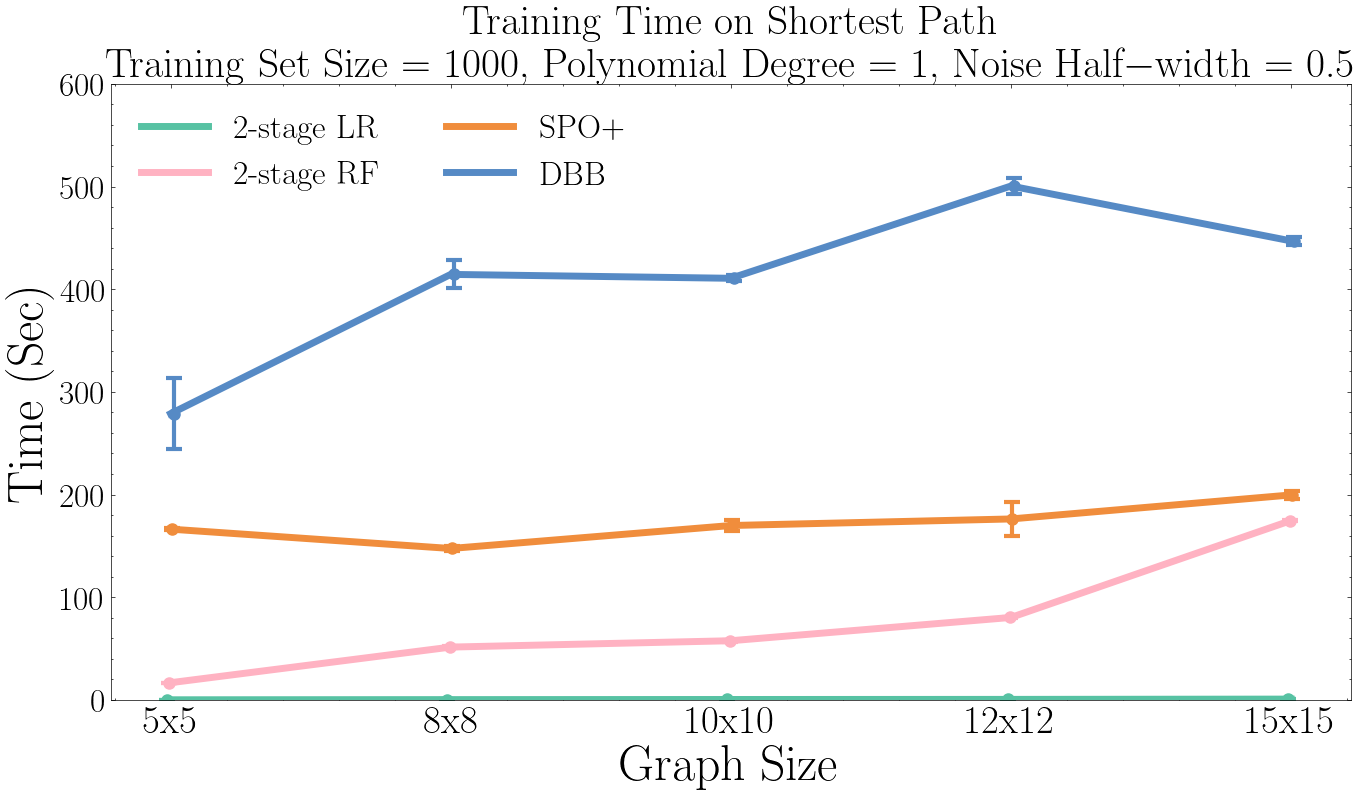

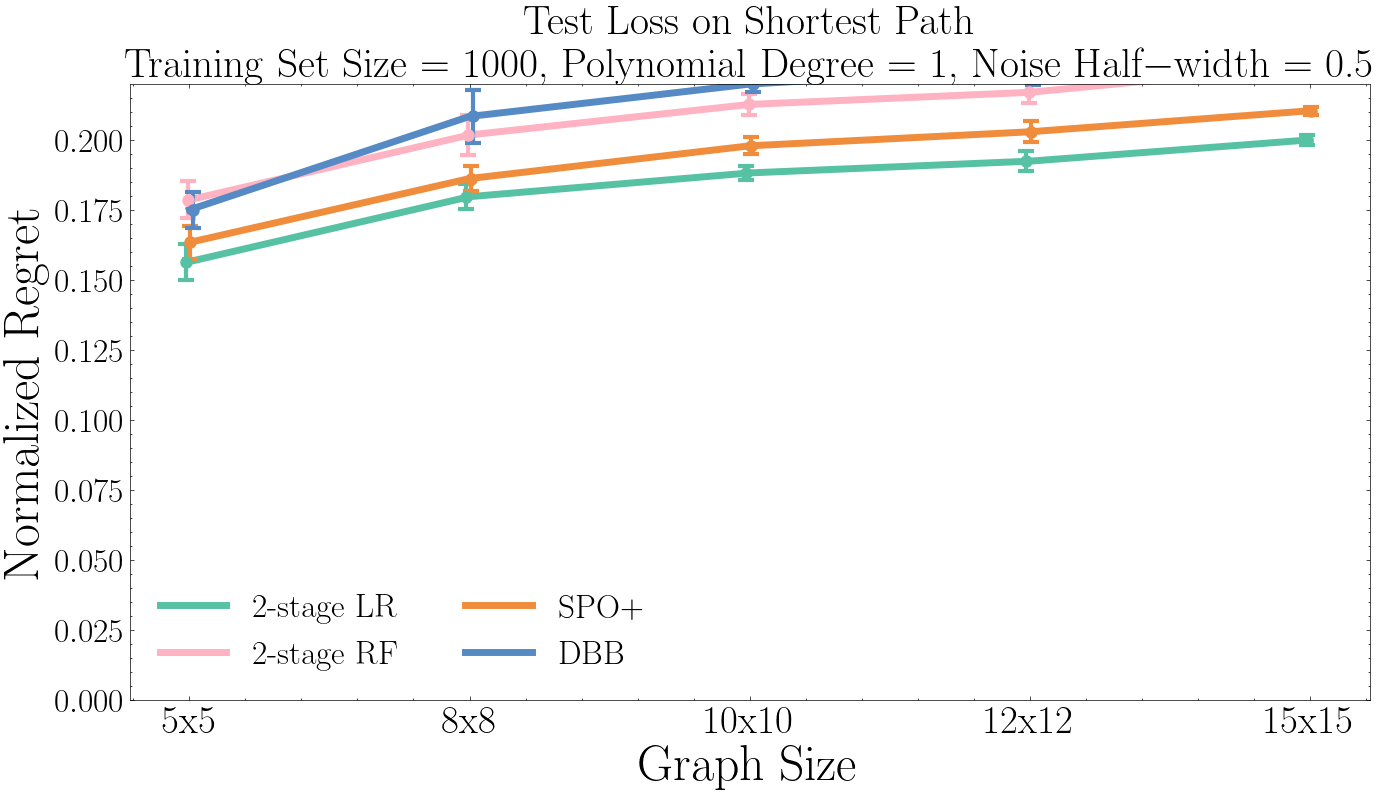

In [8]:
n = 1000
d = 1
e = 0.5
drawPlot(grids, n, d, e)

## Deg = 2 

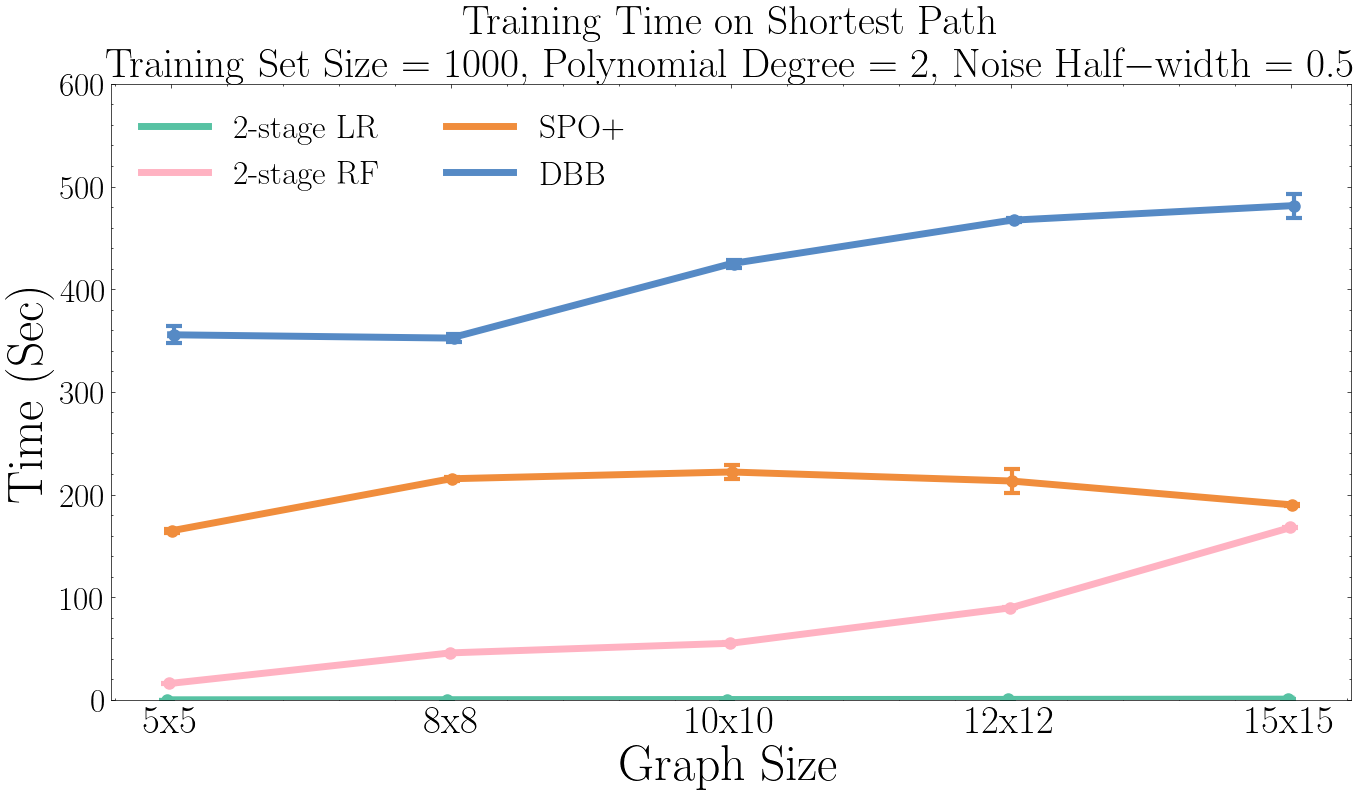

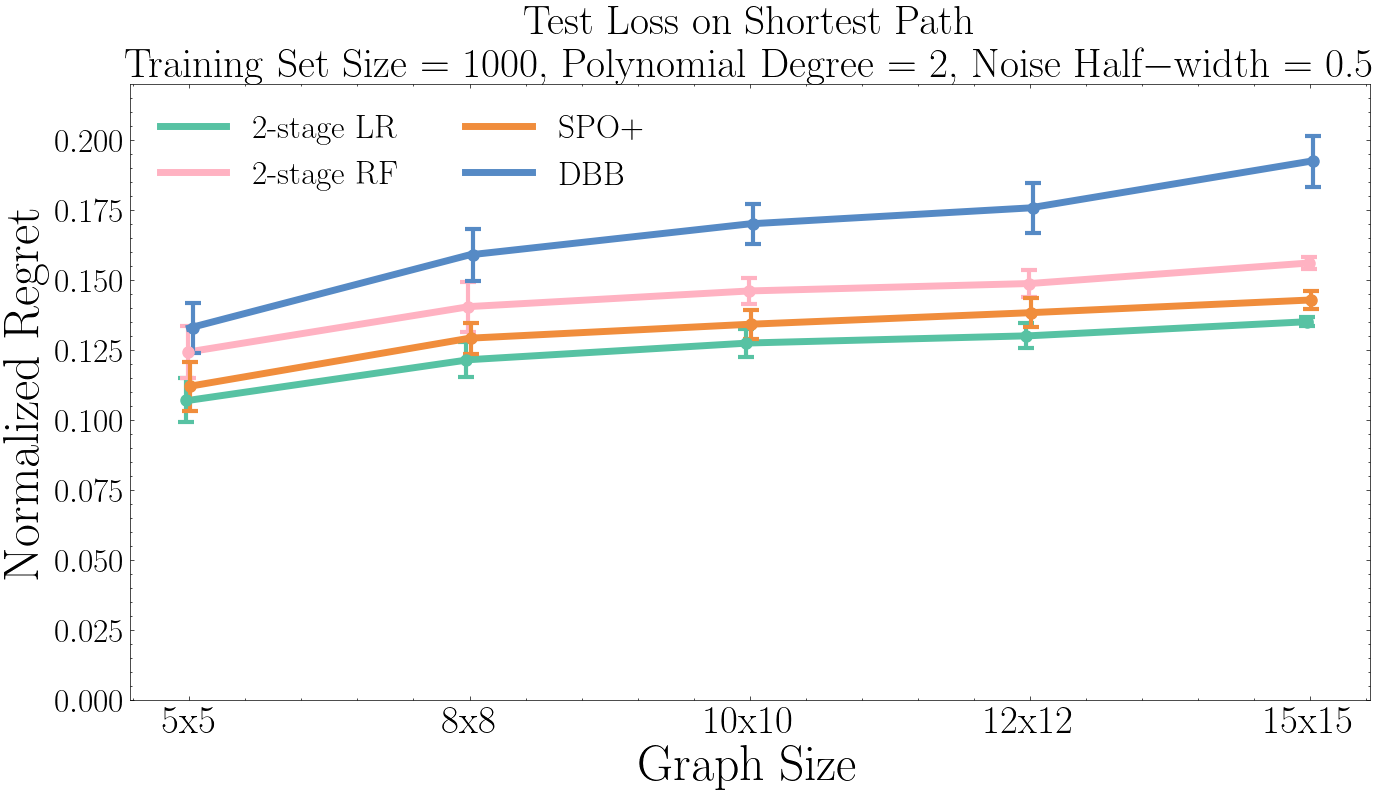

In [9]:
n = 1000
d = 2
e = 0.5
drawPlot(grids, n, d, e)

## Deg = 4 

n = 100
d = 4
e = 0.5
drawPlot(grids, n, d, e)

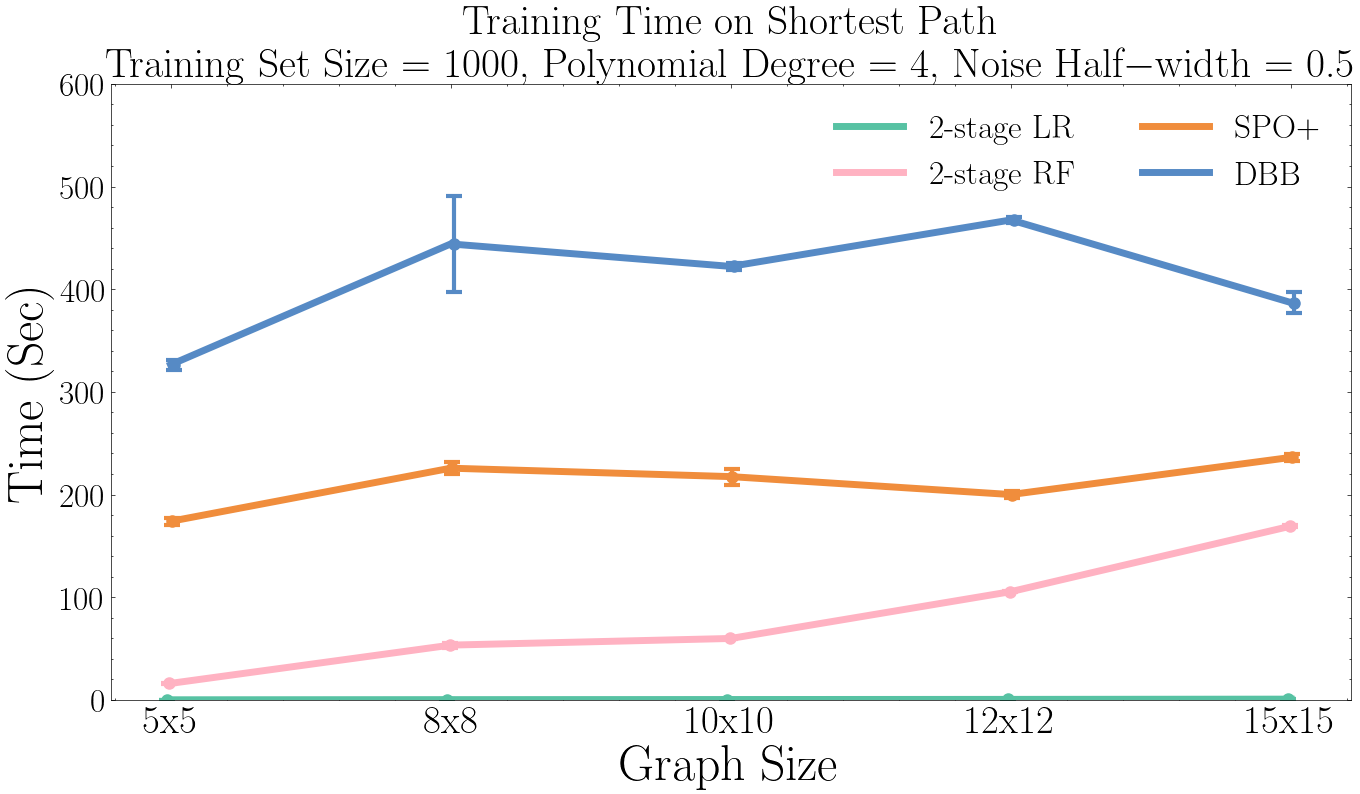

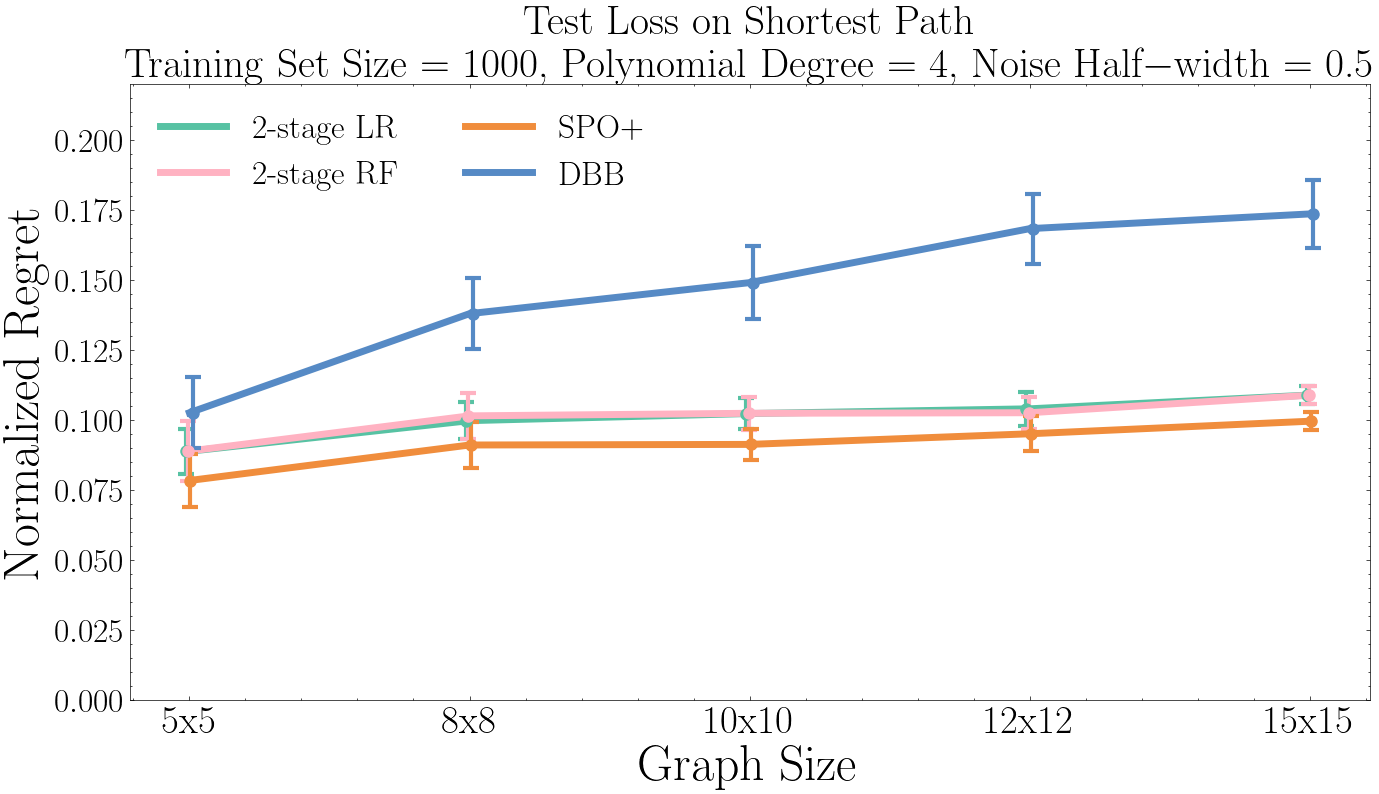

In [10]:
n = 1000
d = 4
e = 0.5
drawPlot(grids, n, d, e)

## Deg = 6

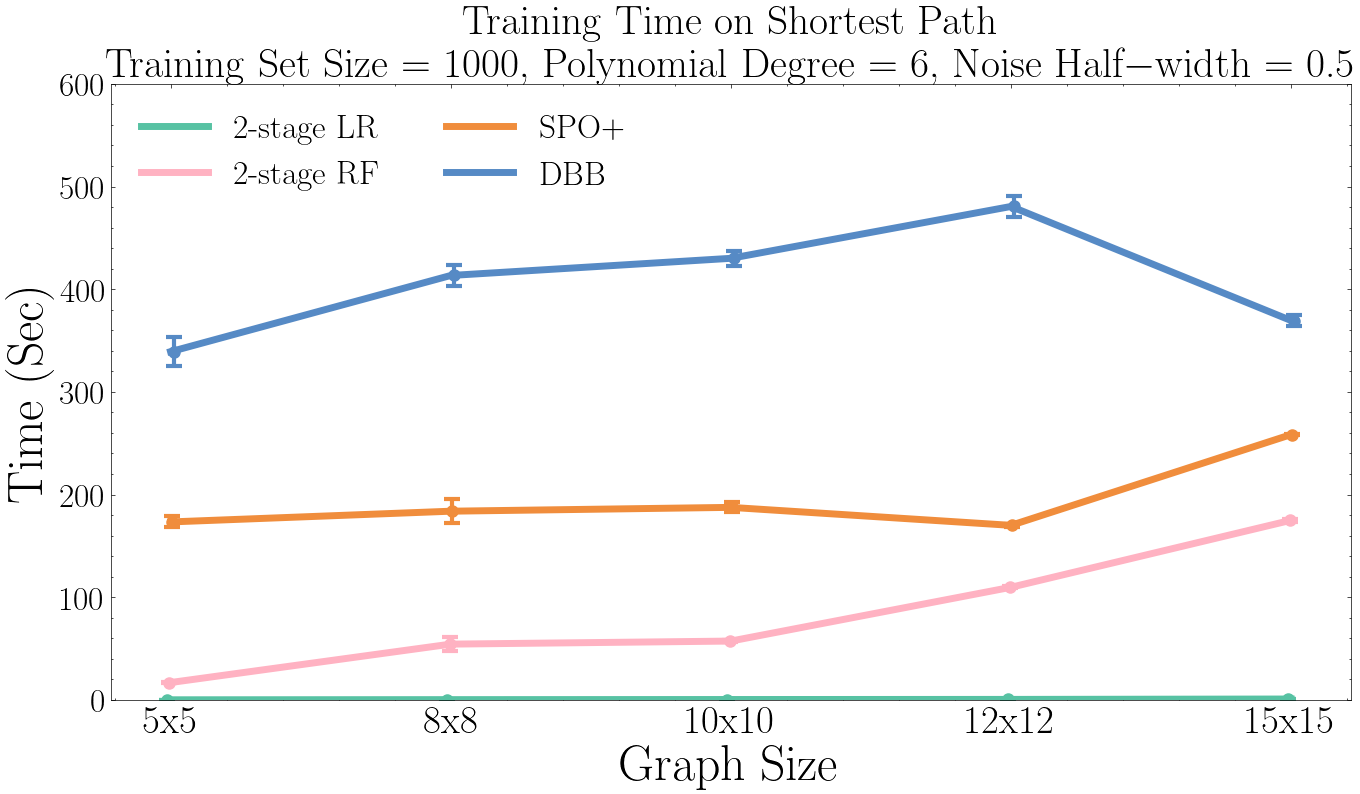

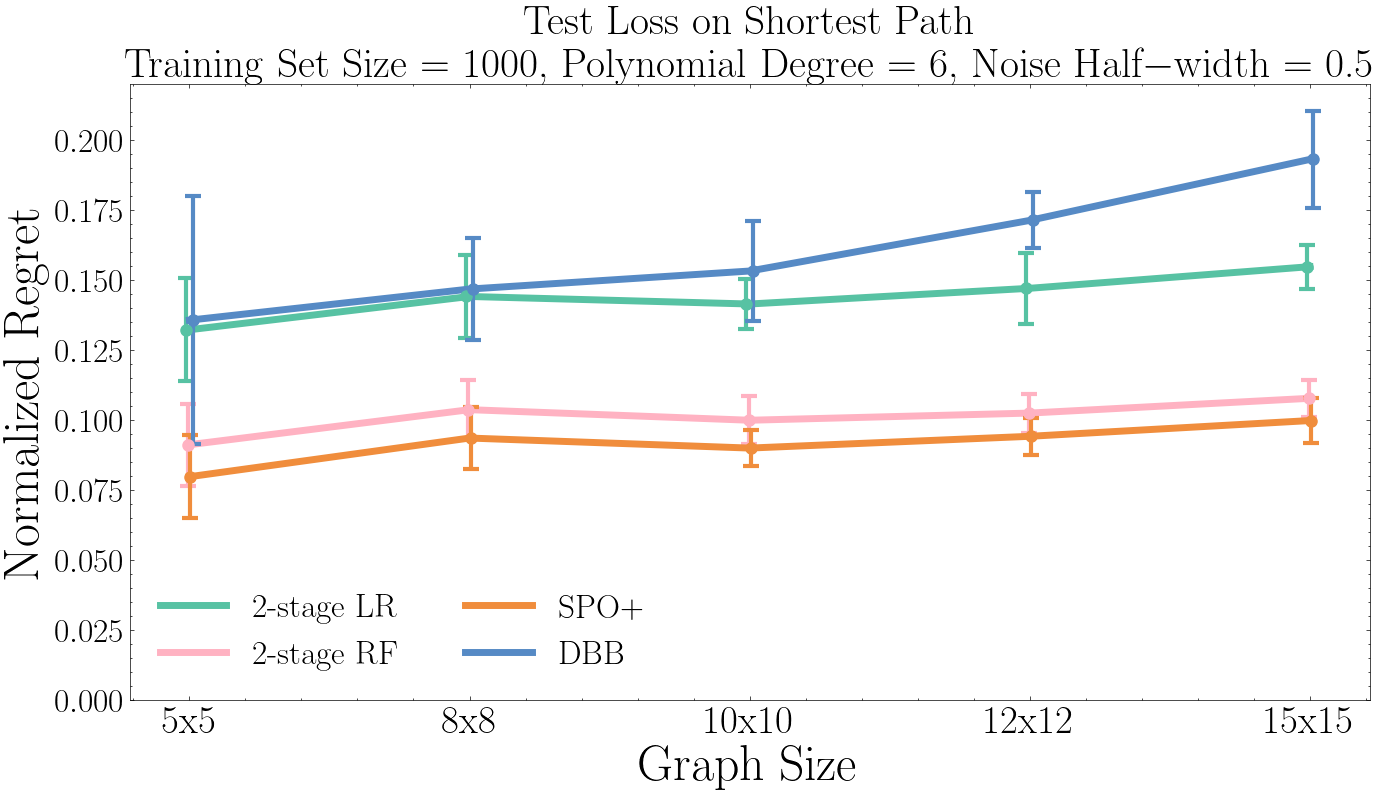

In [11]:
n = 1000
d = 6
e = 0.5
drawPlot(grids, n, d, e)